# Climate Change Prediction Using ARIMA, SARIMA and RNNs

### In this project we try to forecast future climate change based on historical patterns. We collected that data from https://datahub.io/core/global-temp/datapackage.json. You can download the data from:
### 1. Link provided
### 2. From my github https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/ClimateChange_MonthlyStart.csv or
### 3. Install datapackage library
### 4. Dataset contains global land and ocean temperature monthly anomalies.

##
##
##
### We begin by importing useful libraries for this project. 
#### Pandas for reading the data
#### Numpy for faster matrix operations
#### Sklearn for preprocessing and evaluation
#### datapackage to load the data using a url
#### Statstools to build statistical models
#### Keras (Tensorflow background) to build RNNs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import datapackage
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Getting data straight from the website
## You need to have datapackage library installed 
## Just pip install datapackage

data_url = 'https://datahub.io/core/global-temp/datapackage.json'

package = datapackage.Package(data_url)

resources = package.resources
for resources in resources:
    if resources.tabular:
        data = pd.read_csv(resources.descriptor['path'])

In [3]:
data.head()

,Source,Date,Mean
0,GCAG,2016-12,0.7895
1,GISTEMP,2016-12,0.8100
2,GCAG,2016-11,0.7504
3,GISTEMP,2016-11,0.9300
4,GCAG,2016-10,0.7292


In [4]:
data.to_csv('ClimateChange_MonthlyStart.csv')

In [4]:
## Converting date column to datetime type
## Setting Date as index

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True,drop=True)

In [5]:
data.head()

,Source,Mean
Date,,
2016-12-01,GCAG,0.7895
2016-12-01,GISTEMP,0.8100
2016-11-01,GCAG,0.7504
2016-11-01,GISTEMP,0.9300
2016-10-01,GCAG,0.7292


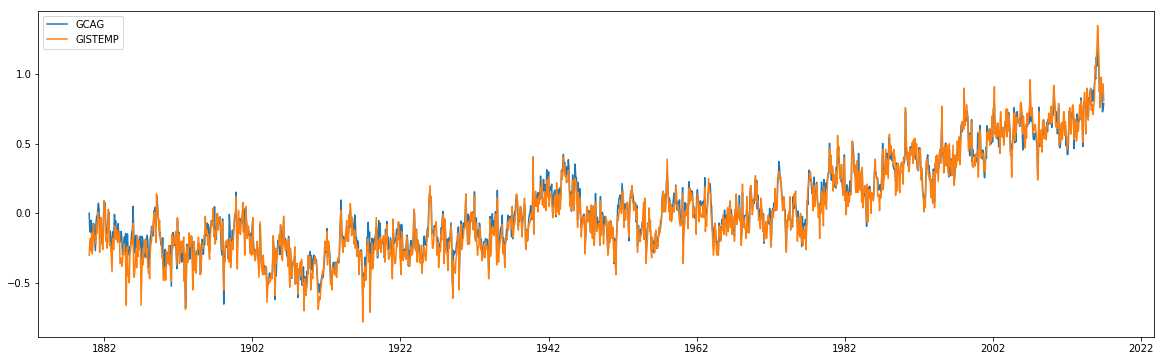

In [6]:
## Plot GCAG and GISTEMP

plt.figure(figsize=(20,6))
plt.plot(data[data['Source']=='GCAG']['Mean'],label='GCAG')
plt.plot(data[data['Source']=='GISTEMP']['Mean'],label='GISTEMP')
plt.legend()

### Since, the dataframe comes with observations from 2 sources, namely GCAG and GISTEMP, we will consider only one source (i.e.) GCAG

In [9]:
GCAG = data[data['Source']=='GCAG']
GCAG = GCAG.sort_index()
GCAG.index.freq = 'MS'
GCAG = GCAG.drop(columns=['Source'])

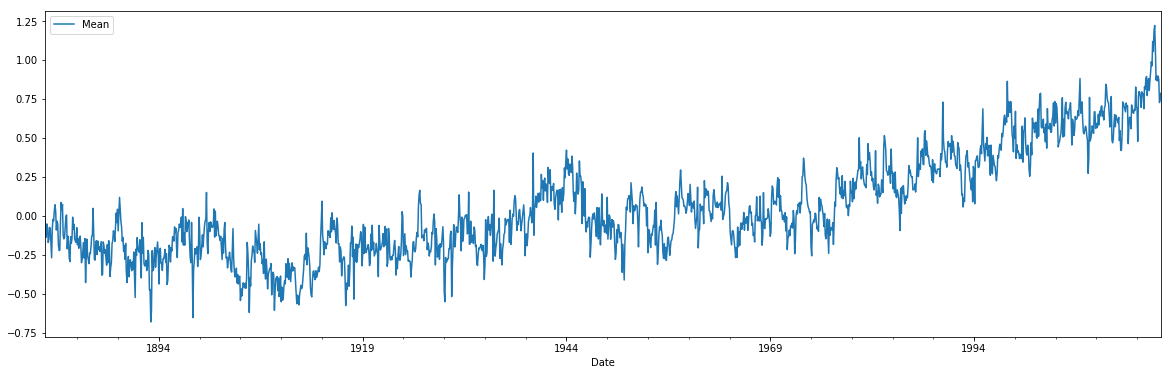

In [10]:
GCAG.plot(figsize=(20,6))

## In order to begin analyzing the data, we begin by testing whether or not the data is stationary. We use Dicky Fuller test to do so. You can read more about Dicky Fuller here: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1911068

## Dicky Fuller Test
### To test stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

adf_test(GCAG['Mean'], title='DFT')

Augmented Dickey-Fuller Test: DFT
ADF test statistic        -0.499547
p-value                    0.892105
# lags used               24.000000
# observations          1619.000000
critical value (1%)       -3.434396
critical value (5%)       -2.863327
critical value (10%)      -2.567721
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## This step lets you deconstruct the time series into several components like:
### 1. Trend: Reflects long term progression of series
### 2. Seasonality: Reflects seasonal variation and checks if seasonal pattern exists in the time series
### 3. Residual: Shows irregular component (or "noise") at time t, which describes random, irregular influences

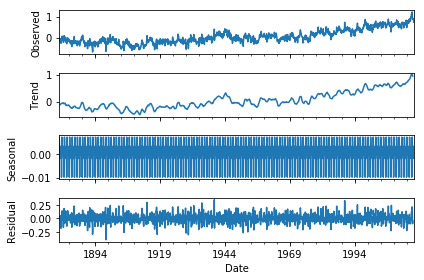

In [14]:
## ETS Graph (Error Trend Seasonality)

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(GCAG['Mean'],model='add')
result.plot();

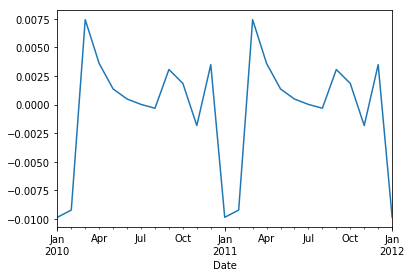

In [15]:
## There exists 12 months seasonality in the dataset

result.seasonal.loc['2010-01-01':'2012-01-01'].plot()

# ARIMA: AR, I, MA
## AR or Autoregression (p): A regression model that uses the dependent relationship between the current observation and observations over a previous period
## I or Integrated (d): Differencing of observations (substracting an observation from an observation at the previous time step) to make the time series stationary
## MA or Moving Average (q): Using past errors to predict the current value. To put it simply if the series is stationary then it will have a constant mean, however at any point in time it may not actually be at the mean. The distance from the mean is called the error.

### ACF: Auto-Correlation Function gives us values of auto-correlation of any series with its lagged values.
### PACF: Partial Auto-Correlation Function finds correlation of the residuals with the next lag value

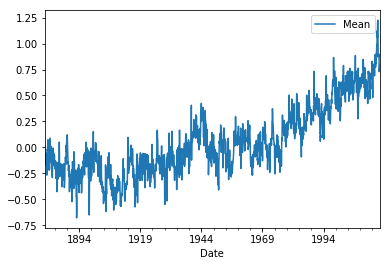

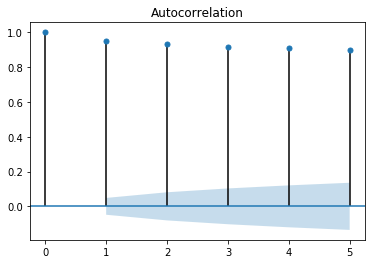

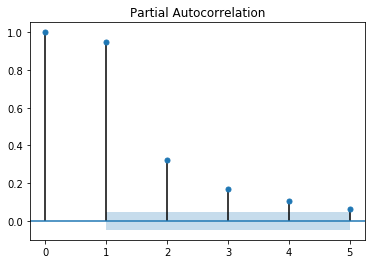

In [17]:
## ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

GCAG.plot();
plot_acf(GCAG,lags=5);
plot_pacf(GCAG,lags=5);

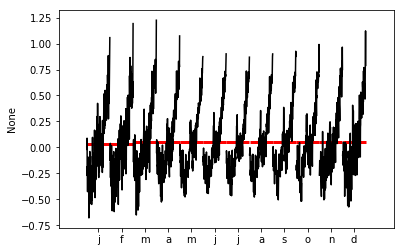

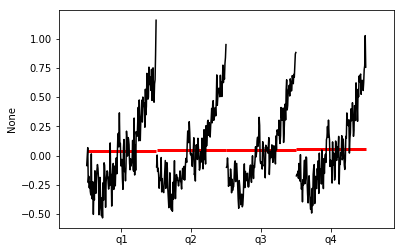

In [13]:
## To check if there exists aggregated monthly and quaterly seasonality over years

from statsmodels.graphics.tsaplots import month_plot, quarter_plot

month_plot(GCAG['Mean']);
dfq = GCAG['Mean'].resample(rule='Q').mean()
quarter_plot(dfq);

In [14]:
years = len(np.unique(GCAG.index.year))
print('Total years of data: %d' %years)

Total years of data: 137


## Divide the dataset into training and validation sets
### Setting training set from: January 1980 to December 2015
### Setting validation set from: January 2016 to December 2016

In [19]:
## Taking last one year of data as testing data

train = GCAG.iloc[:-12]
test = GCAG.iloc[-12:]

In [20]:
print("Train size: %d"%train.shape[0])
print("Test size: %d"%test.shape[0])

Train size: 1632
Test size: 12


### The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

In [21]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(GCAG['Mean'],start_p=0,start_q=0,max_p=5,max_q=3,seasonal=False)
stepwise_fit.summary()

/anaconda3/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/anaconda3/lib/python3.6/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1643
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1560.759
Method:                       css-mle   S.D. of innovations              0.094
Date:                Wed, 22 May 2019   AIC                          -3109.519
Time:                        10:07:06   BIC                          -3077.093
Sample:                             1   HQIC                         -3097.494
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.058      0.040    2.69e-05       0.001
ar.L1.D.y      0.8897      0.026     34.372      0.000       0.839       0.940
ma.L1.D.y     -1.3690      0.036    -37.750      0.000      -1.440      -1.298
ma.L2.D.y      0.3358      0.041      8.124      0.000       0.255       0.417
ma.L3.D.y      0.0460      0.028      1.639      0.101      -0.009       0.101
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1239           +0.0000j            1.1239            0.0000
MA.1            1.0234           +0.0000j            1.0234            0.0000
MA.2            2.0482           +0.0000j            2.0482            0.0000
MA.3          -10.3722           +0.0000j           10.3722            0.5000
-----------------------------------------------------------------------------
"""

In [22]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
model = ARIMA(train['Mean'],order=(1, 1, 3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Mean   No. Observations:                 1631
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1550.423
Method:                       css-mle   S.D. of innovations              0.093
Date:                Wed, 22 May 2019   AIC                          -3088.845
Time:                        10:07:12   BIC                          -3056.464
Sample:                    02-01-1880   HQIC                         -3076.832
                         - 12-01-2015                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.000      2.043      0.041    2.34e-05       0.001
ar.L1.D.Mean     0.8912      0.026     33.868      0.000       0.840       0.943
ma.L1.D.Mean    -1.3750      0.037    -37.494      0.000      -1.447      -1.303
ma.L2.D.Mean     0.3408      0.042      8.189      0.000       0.259       0.422
ma.L3.D.Mean     0.0471      0.028      1.665      0.096      -0.008       0.102
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1221           +0.0000j            1.1221            0.0000
MA.1            1.0238           +0.0000j            1.0238            0.0000
MA.2            2.0182           +0.0000j            2.0182            0.0000
MA.3          -10.2846           +0.0000j           10.2846            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start,
                              end=end,
                              typ='levels').rename('ARIMA (1,1,3) Predictions')

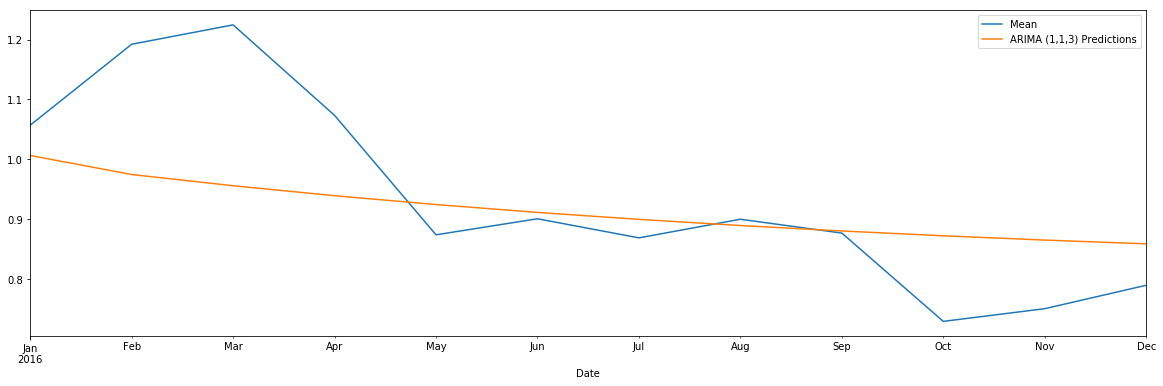

In [24]:
test['Mean'].plot(figsize=(20,6),legend=True)
predictions.plot(legend=True)

## Evaluate ARIMA model by:
### 1. Calculating mean_squared_error and r2_score (below)
### 2. Confidence band (90%, 95%, 99%). This is part of the homework. Read more at https://www2.isye.gatech.edu/~yxie77/isye2028/lecture12.pdf

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

print('MSE: %f'%mean_squared_error(test['Mean'],predictions))
print('RMSE: %f'%np.sqrt(mean_squared_error(test['Mean'],predictions)))
print('R-Squared: %f'%r2_score(test['Mean'],predictions))

MSE: 0.015185
RMSE: 0.123227
R-Squared: 0.383235


## SARIMAX

### Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
### It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [34]:
stepwise_fit = auto_arima(GCAG['Mean'],start_p=0,start_q=0,max_p=5,max_q=3,seasonal=True,m=12)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [35]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1644
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 12)   Log Likelihood                1563.768
Date:                            Wed, 08 May 2019   AIC                          -3113.536
Time:                                    11:24:05   BIC                          -3075.706
Sample:                                         0   HQIC                         -3099.507
                                           - 1644                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.478e-05   7.01e-05      1.067      0.286   -6.26e-05       0.000
ar.L1          0.8519      0.033     26.005      0.000       0.788       0.916
ma.L1         -1.3280      0.042    -31.743      0.000      -1.410      -1.246
ma.L2          0.3540      0.035     10.191      0.000       0.286       0.422
ma.S.L12       0.0106      0.021      0.510      0.610      -0.030       0.051
ma.S.L24       0.1060      0.021      5.045      0.000       0.065       0.147
sigma2         0.0088      0.000     36.456      0.000       0.008       0.009
===================================================================================
Ljung-Box (Q):                       36.61   Jarque-Bera (JB):               121.85
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.05
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Mean'],order=(1, 1, 2),seasonal_order=(0, 0, 2, 12))
results = model.fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start,end=end,typ='levels').rename('SARIMA Predictions')

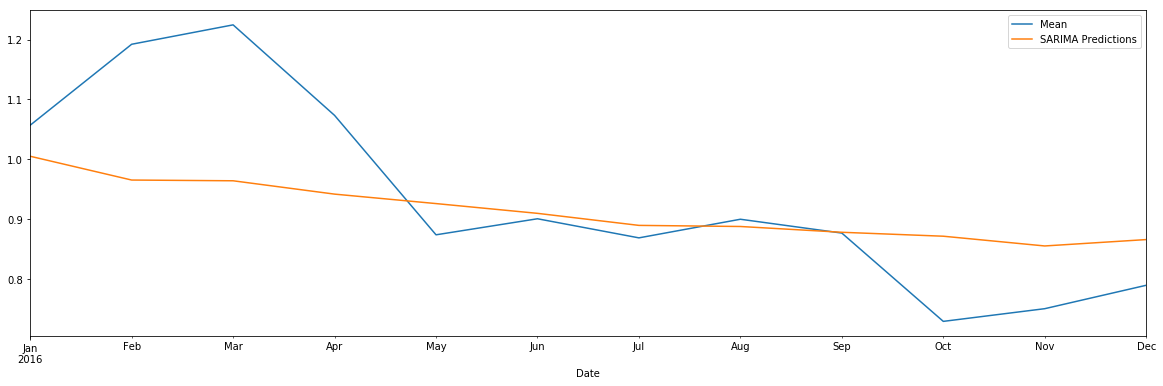

In [28]:
test['Mean'].plot(figsize=(20,6),legend=True)
predictions.plot(legend=True)

In [29]:
print('MSE: %f'%mean_squared_error(test['Mean'],predictions))
print('RMSE: %f'%np.sqrt(mean_squared_error(test['Mean'],predictions)))
print('R-Squared: %f'%r2_score(test['Mean'],predictions))

MSE: 0.014975
RMSE: 0.122372
R-Squared: 0.391760


## FeedForward Neural Networks

### Deep Feedforward networks or also known multilayer perceptrons are the foundation of most deep learning models. The main goal of a feedforward network is to approximate some function f*. For example, a regression function y = f *(x) maps an input x to a value y. A feedforward network defines a mapping y = f (x; θ) and learns the value of the parameters θ that result in the best function approximation.

#
#
## Scaling or Normalization of values
### Scaling or Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.

In [30]:
sc = StandardScaler()
sc.fit(train)

scaled_train = sc.transform(train)
scaled_test = sc.transform(test)

In [31]:
X_train = scaled_train[:-1]
y_train = scaled_train[1:]

X_test = scaled_test[:-1]
y_test = scaled_test[1:]

In [114]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
import keras.backend as K

K.clear_session()
np.random.seed(7)
model = Sequential()
model.add(Dense(7, input_dim=1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Train on 1631 samples, validate on 11 samples
Epoch 1/100
1631/1631 [==============================] - 0s 115us/step - loss: 1.2032 - val_loss: 6.7727
Epoch 2/100
1631/1631 [==============================] - 0s 29us/step - loss: 0.9456 - val_loss: 5.5489
Epoch 3/100
1631/1631 [==============================] - 0s 31us/step - loss: 0.7708 - val_loss: 4.1512
Epoch 4/100
1631/1631 [==============================] - 0s 28us/step - loss: 0.6488 - val_loss: 2.8970
Epoch 5/100
1631/1631 [==============================] - 0s 30us/step - loss: 0.5660 - val_loss: 1.9082
Epoch 6/100
1631/1631 [==============================] - 0s 28us/step - loss: 0.5159 - val_loss: 1.2793
Epoch 7/100
1631/1631 [==============================] - 0s 26us/step - loss: 0.4868 - val_loss: 0.8720
Epoch 8/100
1631/1631 [==============================] - 0s 23us/step - loss: 0.4694 - val_loss: 0.6099
Epoch 9/100
1631/1631 [==============================] - 0s 25us/step - loss: 0.4583 - val_loss: 0.4610
Epoch 10/100
1631

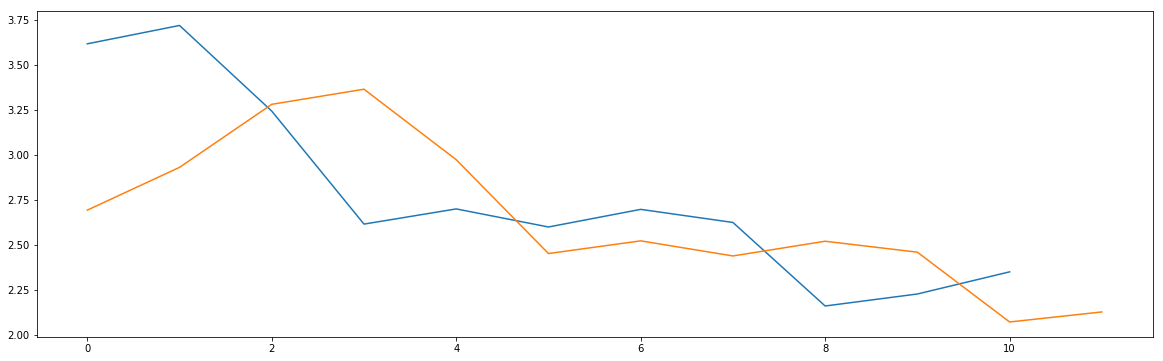

In [115]:
X_test_NN = np.insert(X_test,0,X_train[-1][0])
predictions = model.predict(X_test_NN)
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)

In [116]:
predictions_inv_scaled = sc.inverse_transform(predictions)

In [117]:
print('MSE: %f'%mean_squared_error(test,predictions_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(test,predictions_inv_scaled)))
print('R-Squared: %f'%r2_score(test,predictions_inv_scaled))

MSE: 0.011469
RMSE: 0.107096
R-Squared: 0.534141


# LSTM

## Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

### Read more about LSTM and Deep Neural Networks at:
### https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f
### https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc

#### LSTM needs to define (Batch Size x Nbr of Batches x Features)
###### 3-D tensor

In [127]:
X_train_t = X_train[:,None]
X_test_t = X_test[:,None]

In [128]:
np.random.seed(7)

K.clear_session()
model = Sequential()

model.add(LSTM(20, input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.fit(X_train_t, y_train, validation_data=(X_test_t, y_test), epochs=1000, verbose=0)

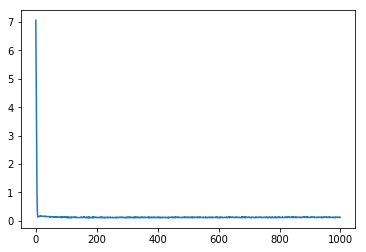

In [129]:
plt.plot(model.history.history['val_loss'])

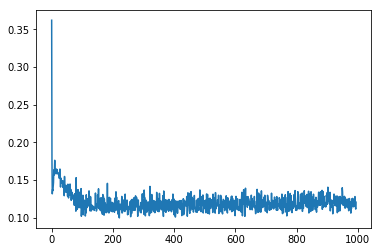

In [136]:
plt.plot(model.history.history['val_loss'][5:])

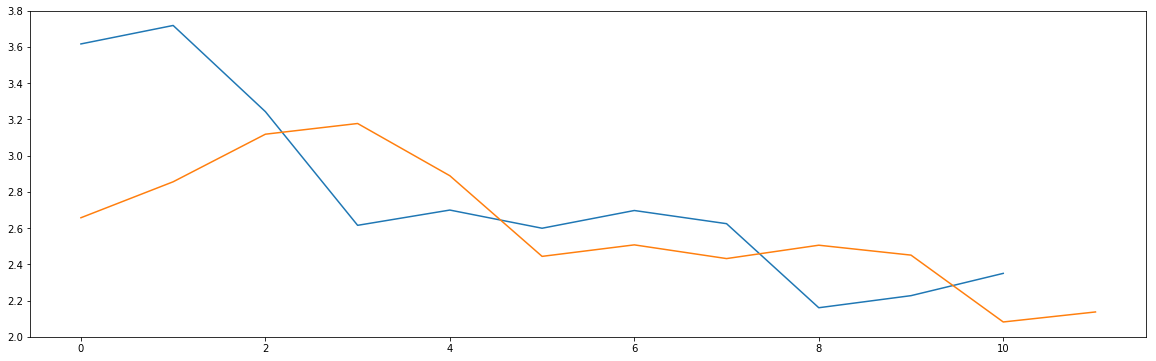

In [130]:
X_test_LSTM = np.insert(X_test,0,X_train[-1][0]).reshape(-1,1)
X_test_LSTM = X_test_LSTM[:,None]
X_test_LSTM.shape
predictions = model.predict(X_test_LSTM)
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)

In [131]:
predictions_inv_scaled = sc.inverse_transform(predictions)

In [132]:
print('MSE: %f'%mean_squared_error(test,predictions_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(test,predictions_inv_scaled)))
print('R-Squared: %f'%r2_score(test,predictions_inv_scaled))

MSE: 0.013581
RMSE: 0.116540
R-Squared: 0.448356


### BIG PROBLEM WITH FORECASTING NEURAL NETWORKS WE BUILT ABOVE:
#### Figure out what the problem is
#### Start a discussion and try to solve the problem
##### Hint: Time series forecast shoud never be based on ground truth.